# A script for analysing past interannual variability in the Ilyas dataset

Dataset used: 

_Ilyas, M., Brierley, C.M. and Guillas, S., 2017. Uncertainty in regional temperatures inferred from sparse global observations: Application to a probabilistic classification of El Niño. Geophysical Research Letters, 44(17), pp.9068-9074._

Code written by Jarmo Kikstra

In [59]:
import numpy as np
import matplotlib.pyplot as plt
#from netCDF4 import Dataset # remove in final version if not actually used.
import pandas as pd
import xarray as xr
import math
from scipy import stats
import pylab

startyr = 1850
endyr = 2016
climateperiod = 30
numyears_data = endyr - startyr + 1

## PAGE-ICE masking functions

### The regions as defined in PAGE-ICE

In [60]:
# Mapping is conform data provided for PAGE-ICE documentation.
regions = {
    1 : 'eu',
    2 : 'rus+',
    3 : 'usa',
    4 : 'chi+',
    5 : 'ind+',
    6 : 'afr',
    7 : 'lat',
    8 : 'oth'    
}
# some parameters to increase readability of the code:
numregions = len(regions)

### Setting up directory and selecting maskig file

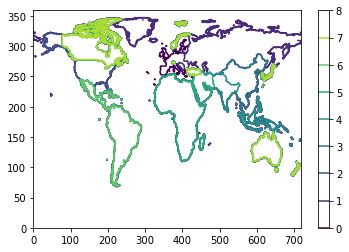

In [61]:
# DOCUMENTATION:
# naming convention:
## grid = Ilyas 36x72 grid
## mask / fullmask = 180 x 360 

# load pagemask.nc file using xarray
dsdir = 'TemperatureVariability/'
dsname = 'pagemask.nc'
DS = xr.open_dataset(dsdir + dsname)
da = DS.world # select variable
mask = da.values # turn dataset into numpy array
# NB.... mask.shape != grid.shape....

#np.place(mask, mask<1, np.nan)
plt.contour(mask)
plt.colorbar()

### Take original masking set and translate it to separate high resolution masking sets

In [62]:
# global variables used:
# - regions

# make 8 separate 1-0 masks, full resolution
def create_separate_masks(fullmask):
    maskingset = np.zeros((len(regions),fullmask.shape[0],fullmask.shape[1]))
    for k in range (1,len(regions)+1):
        for ii in range(fullmask.shape[0]):
            for jj in range(fullmask.shape[1]):
                if fullmask[ii][jj] == k:
                    maskingset[k-1][ii][jj] = 1

    return maskingset
maskingset = create_separate_masks(mask)

### Functions for applying PAGE-masks to a dataset, returning dataset as 3d matrix with (coarse) regionally weighted data

In [63]:
# global variables used:
# - regions, 
# - mask, 
# - maskingset


# now, for eventual calculations, we don't create a 1/0 masking set, but rather just a weighted grid!! 

def create_weighted_grids(grid): # grid should be input of 36 x 72 (so for 1 time entry!!)
    weighted_grid = np.zeros((len(regions), grid.shape[0],grid.shape[1]))
    iratio = int(mask.shape[0]/grid.shape[0]) # = 10
    jratio = int(mask.shape[1]/grid.shape[1]) # = 10
    
    # on the t_anom grid.
    for k in range(len(regions)):
        for i in range(grid.shape[0]): # latitude
            for j in range(grid.shape[1]): # longitude
                weighted_grid[k][i][j] = np.mean(maskingset[k, i*iratio:(i*iratio+iratio), j*jratio:(j*jratio+jratio)]) # ratios of scaling
#                 if weighted_grid[k][i][j] == 0.:
#                     weighted_grid[k][i][j] = np.nan
    return weighted_grid        


## Reading and manipulating data for analysis

### For Median Only

#### Loading data

In [113]:
# load the medians of the temperature anomalies from the datafile
dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/'
dsname = 'median.nc'
DS = xr.open_dataset(dsdir + dsname)
t_anom_ds = DS.temperature_anomaly     # yearly data; [167 x 36 x 72], float32
t_anom = t_anom_ds.values

6.1482916 -4.3221416
(167, 36, 72)
(8, 36, 72)


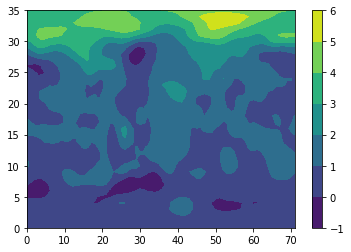

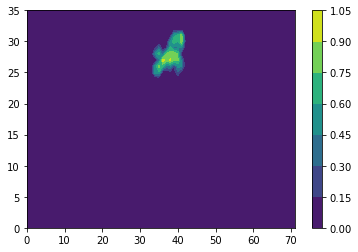

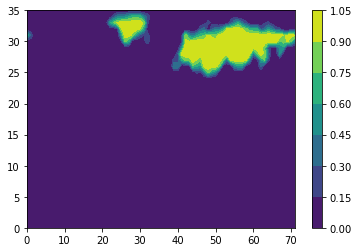

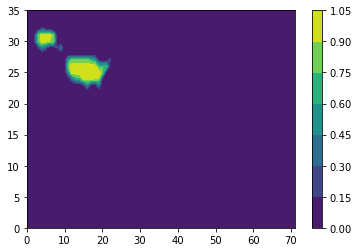

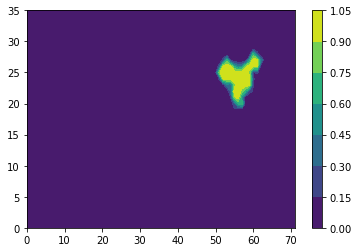

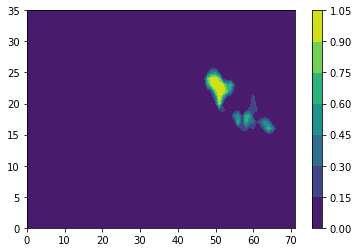

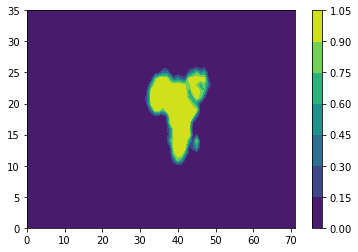

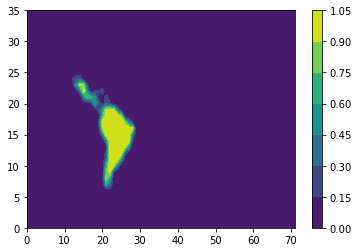

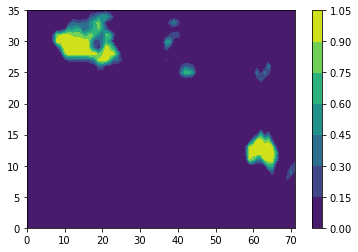

In [112]:
## Some visualisation and checking of the data loaded above:

# print some data to show some characteristic features of the dataset
print(t_anom.max(), t_anom.min())
print(t_anom.shape)

# for visualisation, plot warming pattern in the last (167th) year of analysis (currently 2016)
plt.contourf(t_anom[166])
plt.colorbar()

# call function that applies the page-ice mask and plot its result, 
## with t_anom just serving to provide info on dimensions of the data that is being analysed
weighted_grid = create_weighted_grids(t_anom[1][:][:]) # t_anom only given as argument to get the dimensions of the grid
print(weighted_grid.shape)
# check representation of continents
for i in regions:
    plt.figure()
    plt.contourf(weighted_grid[i-1])
    plt.colorbar()

# Performing analysis

### Create regional mean data 

In [65]:
# global variables used:
# - regions
# - weighted_grid
# - numregions
# - numyears_data
# - ...

# data = t_anom

def do_regional_data(data):
    # some parameters to increase readability of the code:
    grid_lat = data.shape[1]
    grid_lon = data.shape[2]
    
    # create variable to store processed data:
    regional_data = np.zeros((numregions, numyears_data)) # for storing weighted mean temperature (per year and per region)
                              
    # apply masking weights:                           
    # N.B. below highly nested loop is very slow. Is there a quicker way using Linear Algebra?
    for c in range(numregions): # run over all regions
        for year in range(numyears_data): # run over all years
            t_sum = 0
            for i in range(grid_lat): 
                for j in range(grid_lon):
                    # this highly nested loop applies the weights of the masked grid to the data.
                    t_sum = t_sum + (data[year][i][j] * weighted_grid[c][i][j])
            t_mean = t_sum/np.nansum(weighted_grid[c])
            regional_data[c][year] = t_mean     
    
    return regional_data
    
regional_data = do_regional_data(t_anom)






### Detrend a) regional mean data, and b) global mean data.
#### Done by creating a 30yr array for each year, and subtracting the trend from that climatic period. 

In [77]:
# global variables used:
# - t_anom
# - numregions
# - numyears_data
# - climateperiod
    
                    # perhaps add argument and adaptable code to specify the form of detrending
def detrend_data_and_climatic_data(regional_data):    
    
    # create variable to store processed data:
    regional_data_detrended = np.zeros((numregions, numyears_data, climateperiod)) # for storing detrended weighted mean temperature (per year and per region)
    regional_clim_data = np.zeros((numregions, numyears_data))
    
    # regional detrending - take linear trend for every 30yr climatic period 
## check ceil and floor....
    for c in range(numregions):
        for k in range(numyears_data):            
            if k < math.floor(climateperiod/2): # first set of detrended regional data will be filled with nan.
                regional_data_detrended[c][k] = np.nan
                regional_clim_data[c][k] = np.nan
            elif k >= (numyears_data - math.ceil(climateperiod/2)):
                regional_data_detrended[c][k] = np.nan
                regional_clim_data[c][k] = np.nan
            else:
                # do (linear=1) fitting on the selected data [x,y,orderpolynomial]:
                selecteddatawindow = np.squeeze(regional_data[c, (k-math.floor(climateperiod/2)):(k+math.ceil(climateperiod/2))])
                fit = np.polyfit(list(range(climateperiod)), selecteddatawindow, 1)    
                f = np.poly1d(fit)              
                                
                # subtract fit from regional_data and put that into regional_data_detrended
                regional_data_detrended[c][k][:] = selecteddatawindow - f(list(range(climateperiod)))
                
                # save climatic data
                regional_clim_data[c][k] = np.mean(selecteddatawindow)
                
                
    
    
    # global detrending - take linear trend for every 30yr climatic period 
    t_anom_mean = np.zeros(numyears_data)
    for k in range(numyears_data):
        t_anom_mean[k] = np.mean(t_anom[k])
    
    # create variable to store processed data:
    global_data_detrended = np.zeros((numyears_data, climateperiod))
    global_clim_data = np.zeros(numyears_data)
    for k in range(numyears_data):
        if k < math.floor(climateperiod/2):
            global_data_detrended[k] = np.nan
            global_clim_data[k] = np.nan
        elif k >= (numyears_data - math.ceil(climateperiod/2)):
            global_data_detrended[k] = np.nan
            global_clim_data[k] = np.nan
        else: 
            selecteddatawindow = np.squeeze(t_anom_mean[(k-math.floor(climateperiod/2)):(k+math.ceil(climateperiod/2))])
            fit = np.polyfit(list(range(climateperiod)), selecteddatawindow, 1)    
            f = np.poly1d(fit)
            
            # subtract fit from global_data and put that into global_data_detrended
            global_data_detrended[k][:] = selecteddatawindow - f(list(range(climateperiod)))
            
            # save climatic data
            global_clim_data[k] = np.mean(selecteddatawindow)
    
    
    
    
    return regional_data_detrended, global_data_detrended, regional_clim_data, global_clim_data
                 
    
regional_data_detrended, global_data_detrended, regional_clim_data, global_clim_data = detrend_data_and_climatic_data(regional_data)

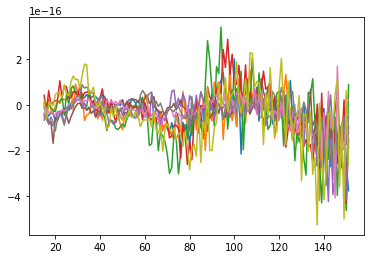

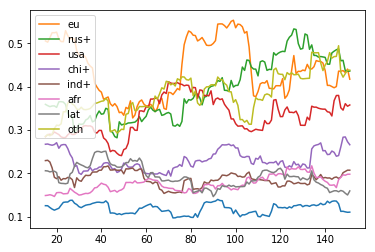

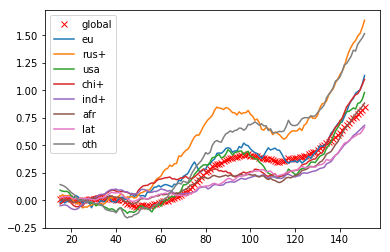

In [80]:
# check the data output:

# means - should be close to zero (or close to zero)
plt.figure()
plt.plot(range(regional_data.shape[1]), np.mean(global_data_detrended, axis=1))
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), np.mean(regional_data_detrended[c], axis=1))

# standard deviations:
plt.figure()
plt.plot(range(regional_data.shape[1]), np.std(global_data_detrended, axis=1))
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), np.std(regional_data_detrended[c], axis=1), label = regions[c+1])
plt.legend()

# climatic temperatures:
plt.figure()
plt.plot(range(regional_data.shape[1]), global_clim_data, 'rx', label = 'global')
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), regional_clim_data[c], label = regions[c+1])
plt.legend()

mean SD of eu 0.43941458985252696
mean SD of rus+ 0.39208641481909967
mean SD of usa 0.3323108252448465
mean SD of chi+ 0.2307828746522904
mean SD of ind+ 0.1881744379998522
mean SD of afr 0.17533652935806862
mean SD of lat 0.19202658649002732
mean SD of oth 0.38255050556480424
global mean SD 0.11903452908343239


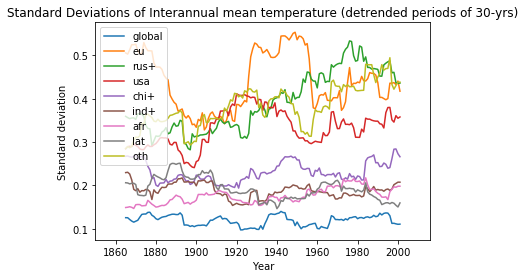

In [107]:
# global variables used:
# - startyr
# - endyr
# - regions
# - numregions
# - numyears_data

def calculate_std(regional_data_detrended, global_data_detrended):
    regional_std = np.zeros((numregions, numyears_data))
    global_std = np.zeros(numyears_data)
    for k in range(numyears_data):
        global_std[k] = np.std(global_data_detrended[k])
        for c in range(numregions):
            regional_std[c][k] = np.std(regional_data_detrended[c][k][:])
    return regional_std, global_std

regional_std, global_std = calculate_std(regional_data_detrended, global_data_detrended)

# plot standard deviations over time:
plt.figure()
plt.plot(range(startyr,endyr+1), global_std, label = 'global')
for c in range(numregions):
    plt.plot(range(startyr,endyr+1), regional_std[c], label = regions[c+1])
plt.xlim(startyr, endyr)
plt.title('Standard Deviations of Interannual mean temperature (detrended periods of 30-yrs)')
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Standard deviation')
    # print mean SDs
for c in range(numregions):
    print('mean SD of ' + str(regions[c+1]) + ' ' + str(np.nanmean(regional_std[c])))
print('global mean SD' + ' ' + str(np.nanmean(global_std)))

In [110]:
def calculate_correlations(regional_std, global_std, regional_clim_data, global_clim_data):
    
    
    spearman_correlations_regional_rmt = np.zeros((len(regions),2))
    pearson_correlations_regional_rmt = np.zeros((len(regions),2))
    anova_ftest_regional_rmt = np.zeros((len(regions),2))
    for c in range(numregions):
        # temporarily get rid of nan entries:
        A = regional_std[c][~np.isnan(regional_std[c])]
        B = regional_clim_data[c][~np.isnan(regional_clim_data[c])]
        # use different statistical techniques (these should probably be made more robust):
        spearman_correlations_regional_rmt[c] = stats.spearmanr(A,B) # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        pearson_correlations_regional_rmt[c] = stats.pearsonr(A,B) # stats.pearsonr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        anova_ftest_regional_rmt[c] = stats.f_oneway(A,B) # stats.f_oneway(A,B) -- takes: two arrays -- returns: f-value, p-value || The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid. 1) The samples are independent. 2) Each sample is from a normally distributed population. 3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
    
    spearman_correlations_regional_gmt = np.zeros((len(regions),2))
    pearson_correlations_regional_gmt = np.zeros((len(regions),2))
    anova_ftest_regional_gmt = np.zeros((len(regions),2))
    for c in range(numregions):
        # temporarily get rid of nan entries:
        A = regional_std[c][~np.isnan(regional_std[c])]
        B = global_clim_data[~np.isnan(global_clim_data)]
        # use different statistical techniques (these should probably be made more robust):
        spearman_correlations_regional_gmt[c] = stats.spearmanr(A,B) # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        pearson_correlations_regional_gmt[c] = stats.pearsonr(A,B) # stats.pearsonr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        anova_ftest_regional_gmt[c] = stats.f_oneway(A,B) # stats.f_oneway(A,B) -- takes: two arrays -- returns: f-value, p-value || The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid. 1) The samples are independent. 2) Each sample is from a normally distributed population. 3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
    
    print(spearman_correlations_regional_rmt)
    print(pearson_correlations_regional_rmt)
    print(anova_ftest_regional_rmt)
    print(spearman_correlations_regional_gmt)
    print(pearson_correlations_regional_gmt)
    print(anova_ftest_regional_gmt)
        
calculate_correlations(regional_std, global_std, regional_clim_data, global_clim_data)



[[ 1.84992626e-01  3.04521602e-02]
 [ 7.45160267e-01  1.61484806e-25]
 [ 5.51024885e-01  3.01699585e-12]
 [ 2.98163982e-01  4.01970876e-04]
 [-8.54163944e-02  3.20988865e-01]
 [ 6.02787164e-01  6.51038336e-15]
 [-5.55332574e-01  1.88376545e-12]
 [ 7.39242444e-01  6.09380622e-25]]
[[ 1.37895735e-01  1.08070610e-01]
 [ 7.36572063e-01  1.09662532e-24]
 [ 4.81731663e-01  2.52708759e-09]
 [ 3.61253157e-01  1.44437651e-05]
 [ 9.99501155e-03  9.07716278e-01]
 [ 4.96287509e-01  6.94812177e-10]
 [-5.78596736e-01  1.31195232e-13]
 [ 7.20231500e-01  3.44063529e-23]]
[[2.92583113e+01 1.38867467e-07]
 [1.27627754e+01 4.18086187e-04]
 [1.60396321e+01 8.00957132e-05]
 [2.74828460e+00 9.85116443e-02]
 [1.30977787e+00 2.53440970e-01]
 [1.43734143e+00 2.31613469e-01]
 [5.76864925e-01 4.48201542e-01]
 [1.76856984e+00 1.84673274e-01]]
[[ 3.83645715e-01  3.69837071e-06]
 [ 8.50869005e-01  1.47434335e-39]
 [ 4.19068643e-01  3.45575614e-07]
 [ 5.00326694e-01  4.80334789e-10]
 [-2.04220882e-01  1.66781713e-02

# BELOW: old code for possible future reference.

## N.B. the code below should not be used as it is now 

# To-do list:
#### !!!) DETREND FOR 'moving 30yr frame' regional (linear) TEMPERATURE TREND (NB. this is not similar to 'anthropogenic warming', but should capture interannual variability)
#### 1) check splitting up for nan (var) and not nan (mean)
#### 2) check why e.g. t_anom_mean becomes smaller --> how to deal with end of data, selecting the range.
##### --> ESPECIALLY SINCE VARIANCE SUDDENLY DECREASES IN THE LAST 15 YEARS, unexpectedly?
#### .) extend annual data for the entire range, beyond climatic data.
Stuff to still do in later stages:
1) use pandas rather than a m-dimension array
2) ...
3) ...

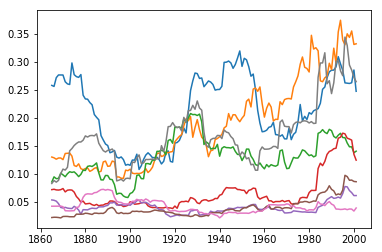

In [141]:
# NOTE:
## FOR NOW, i have just quickly taken the regional_data_detrended and put them into the place of the 
## old regional_data
# ALSO NOTE:
## the global data should also have been detrended now
def do_analysis(regional_data, regional_data_notdetrended, data): # data just for shape, again, change later when cleaning code (t_anom is accessible globally)
    # analysis parameters
    climateperiod = 30 # climatological period over which the interannual variability is determined
    analysis_range = [startyr + int(climateperiod/2), endyr - int(climateperiod/2)]
    analysis_duration = data.shape[0] - climateperiod
    
    
    
    # regional variables
    variance_matrix = np.zeros((len(regions), analysis_duration)) # always climatic [over climateperiod]
    rmt_clim_matrix = np.zeros((len(regions), analysis_duration))
    rmt_clim_matrix_notdetrended = np.zeros((len(regions), analysis_duration))
    rmt_ann_matrix = np.zeros((len(regions), analysis_duration))
    
    # global (all of the globe) variables
    gmt_clim_matrix = np.zeros(analysis_duration)
    gmt_clim_matrix_notdetrended = np.zeros(analysis_duration)
    gmt_ann_matrix = np.zeros(analysis_duration)
    variance_matrix_global = np.zeros(analysis_duration) # always climatic [over climateperiod]
    
    # global (over land) variables
    land_clim_matrix = np.zeros(analysis_duration)
    land_clim_matrix_notdetrended = np.zeros(analysis_duration)
    land_ann_matrix = np.zeros(analysis_duration)
    variance_matrix_land = np.zeros(analysis_duration) # always climatic [over climateperiod]
    
    # data storages variables -- gmt_mean[yr]
    t_anom_mean = np.zeros(167)
    t_anom_mean_land = np.zeros(167)
    detrended_global_means = np.zeros(167)
    detrended_land_means = np.zeros(167)
    for year in range(167):
        detrended_global_means[year] = np.mean(data[year]) - g_temperaturetrend[year]
        for c in regions: # run over all regions
            c = c - 1
            detrended_land_means[year] = np.mean(regional_data[:,year]) - g_temperaturetrend[year]
            
    for year in range(167):
    # note that this should be data for 1865-2001 --- print(analysis_range) -- CHECK: range
        # global mean temperatures
        t_anom_mean[year] = detrended_global_means[year]
        t_anom_mean_land[year] = np.mean(regional_data[:, year])
    
    

    for c in regions: # run over all regions
        c = c - 1
#         for year in range(167): # run over all years
            # apply weighting
            # regional_data[c][year] = np.nanmean(np.multiply(data[year], weighted_grid[c])) # t[year] * weighted_mask
            ## above is an incorrect way --> every point needs to be weighted differently in the mean...
                         
        # VARIANCE
        for year in range(analysis_duration): # note that this should be data for 1865-2001 --- print(analysis_range)
            # Returns the variance of the array elements, a measure of the spread of a distribution.
            variance_matrix[c][year] = np.var(regional_data[c,(year):(year+int(climateperiod))]) # calculate variance for 30 years around 'year'
                    
        # TEMPERATURE
            # calculate regional mean temperature [rmt] (over climateperiod)
#         for year in range(analysis_duration):    
            rmt_ann_matrix[c][year] = regional_data[c][year]
            rmt_clim_matrix[c][year] = np.mean(regional_data[c,(year):(year+int(climateperiod))]) # calculate rmt for 30 years around 'year'
            rmt_clim_matrix_notdetrended[c][year] = np.mean(regional_data_notdetrended[c,(year):(year+int(climateperiod))])
        
        
    for year in range(analysis_duration): 

        # calculate global mean temperature variance || calculate mean temperature variance over land
        variance_matrix_global[year] = np.var(t_anom_mean[(year):(year+int(climateperiod))]) # calculate gmt for 30 years around 'year'
        variance_matrix_land[year] = np.var(t_anom_mean_land[(year):(year+int(climateperiod))])
        
        # calculate global mean temperature || calculate mean temperature over land
        gmt_ann_matrix = t_anom_mean # is for the entire data period (167 yrs)
        gmt_clim_matrix[year] = np.mean(t_anom_mean[(year):(year+int(climateperiod))]) # calculate gmt for 30 years around 'year'
        gmt_clim_matrix_notdetrended[year] = np.mean(data[year])
        land_ann_matrix[year] = np.mean(regional_data[:, year]) # could extend for all of the data period, now just for (137 yrs)
        land_clim_matrix[year] = np.mean(regional_data[:,(year):(year+int(climateperiod))])           
        land_clim_matrix_notdetrended[year] = detrended_land_means[year] + g_temperaturetrend[year]                                     
                                              
            
            # calculate ...

            
    return variance_matrix, rmt_clim_matrix, rmt_ann_matrix, gmt_ann_matrix, gmt_clim_matrix, variance_matrix_global, variance_matrix_land, land_ann_matrix, land_clim_matrix, t_anom_mean, rmt_clim_matrix_notdetrended, gmt_clim_matrix_notdetrended, land_clim_matrix_notdetrended

# running the function and taking the output
variance_matrix, rmt_clim_matrix, rmt_ann_matrix, gmt_ann_matrix, gmt_clim_matrix, variance_matrix_global, variance_matrix_land, land_ann_matrix, land_clim_matrix, t_anom_mean, rmt_clim_matrix_notdetrended, gmt_clim_matrix_notdetrended, land_clim_matrix_notdetrended = do_analysis(regional_data_detrended, regional_data, t_anom)
# print(regional_data, variance_matrix, rmt_clim_matrix, rmt_ann_matrix, gmt_ann_matrix, gmt_clim_matrix, variance_matrix_global, variance_matrix_land, land_ann_matrix, land_clim_matrix)    
for i in range(8):
    plt.plot(range(1865,2002), variance_matrix[i,:])


#### Find statistical representations (per region)

In [137]:
# Step 1a, 1b, 1c.: best fit line [a. v = constant b. v = at+b, b. v = at^2+bt+c]

#### Plotting the results coming from above analysis

Climatic RMT --> RMT variance eu [4.12324752e-01 5.54343641e-07]
Climatic RMT --> RMT variance rus+ [8.31365393e-01 2.95792412e-36]
Climatic RMT --> RMT variance usa [7.27999515e-01 6.89790655e-24]
Climatic RMT --> RMT variance chi+ [4.88747736e-01 1.36649862e-09]
Climatic RMT --> RMT variance ind+ [0.15310266 0.07407547]
Climatic RMT --> RMT variance afr [7.37081599e-01 9.80863835e-25]
Climatic RMT --> RMT variance lat [-3.39341386e-01  4.98061581e-05]
Climatic RMT --> RMT variance oth [6.60625945e-01 1.58915524e-18]


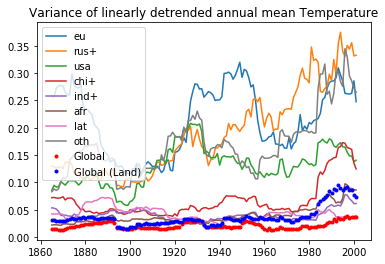

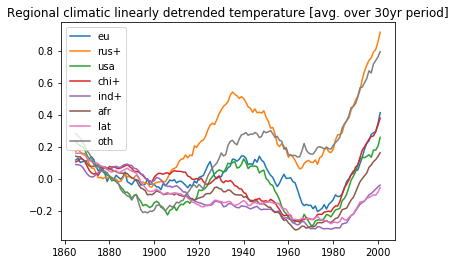

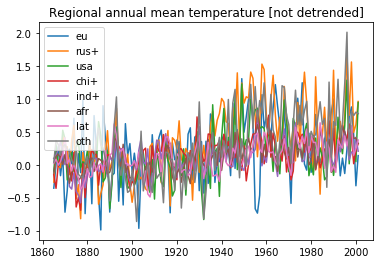

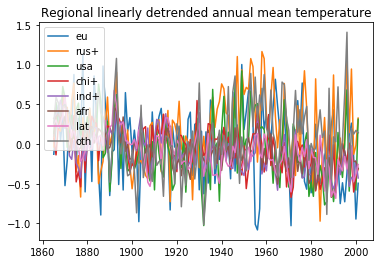

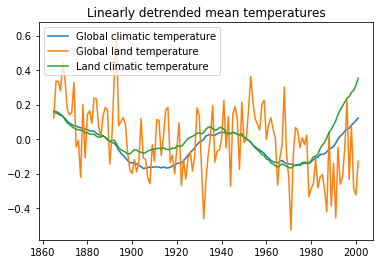

In [145]:
#############
# VARIANCE
#############
# plotting running variance for the different regions:
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)),variance_matrix[i-1,:], label = regions[i])  ### is not responding to detrending
plt.title('Variance of linearly detrended annual mean Temperature')

# plotting running global variance:
plt.plot(list(range(1865,2002)), variance_matrix_global, 'r.', label = 'Global')
plt.legend(loc='upper left')
plt.plot(list(range(1865,2002)), variance_matrix_land, 'b.', label = 'Global (Land)')
plt.legend(loc='upper left')



#############
# TEMPERATURE
#############
# plotting average climatic regional temperature anomalies:
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)), rmt_clim_matrix[i-1,:], label = regions[i]) 
plt.title('Regional climatic linearly detrended temperature [avg. over 30yr period]')
plt.legend(loc='upper left')
# for control, plot the yearly temperatures:
rmt_ann_matrix_notdetrended = np.zeros(rmt_ann_matrix.shape)
for c in regions: # run over all regions
        c = c - 1
        for year in range(137):     
            rmt_ann_matrix_notdetrended[c][year] = regional_data[c][year]
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)), rmt_ann_matrix_notdetrended[i-1,:], label = regions[i])
plt.title('Regional annual mean temperature [not detrended]')
plt.legend(loc='upper left')
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)), rmt_ann_matrix[i-1,:], label = regions[i])
plt.title('Regional linearly detrended annual mean temperature')
plt.legend(loc='upper left')
# global yearly temperatures with the climatic temperature overlayed:
plt.figure() 
plt.plot(list(range(1865,2002)), gmt_clim_matrix, label = 'Global climatic temperature')
plt.plot(list(range(1865,2002)), land_ann_matrix, label = 'Global land temperature')      
plt.plot(list(range(1865,2002)), land_clim_matrix, label = 'Land climatic temperature')
plt.title('Linearly detrended mean temperatures')
plt.legend(loc='upper left')

    
    
    
###### ALLLL OF THE BELOW SHOULD BE REVISED, RESULTS DON'T MAKE SENSE (e.g. detrended land temperature should not go down, p-values still too low, etc.)    
    # find the correlations: reg_variance = f(rmt) || reg_variance = f(gmt) || global(all)_variance = f(gmt)
            # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value
corrNp_rmt_var = np.zeros((len(regions),2))
corrNp_gmt_var = np.zeros((len(regions),2))
corrNp_gmt_gmtvar = np.zeros(2)
for i in regions:
    i = i-1
    corrNp_rmt_var[i] = stats.spearmanr(rmt_clim_matrix_notdetrended[i,:], variance_matrix[i,:])
    corrNp_gmt_var[i] = stats.spearmanr(gmt_clim_matrix_notdetrended[:], variance_matrix[i,:])
corrNp_gmt_gmtvar[:] = stats.spearmanr(gmt_clim_matrix_notdetrended[:], variance_matrix_global[:])

for i in regions:
    print('Climatic RMT --> RMT variance', regions[i], corrNp_rmt_var[i-1])
    #print('Climatic GMT --> RMT variance', regions[i], corrNp_gmt_var[i-1])
# print('Climatic GMT --> GMT variance',corrNp_gmt_gmtvar)
##########################
# first conclusions:
## 1) 'ind+' and 'lat' do not have significant p-values
## 2) otherwise, the relation with GMT and RMT is pretty similar for each region.
## 3) correlations are mostly in the range of 0.4-0.9
## 4) --- perhaps note that linear detrending underestimates global warming trend in the most recent decades

#### To be worked on::::

### For Multiple Ensemble Members --- including uncertainty

In [164]:
# using netCDF4.Dataset
for i in range(startyr, startyr + 1):
    # location of the Ilyas2017 data files
    location = '/data/aod/Ilyasetal2017_annual/wrt_18501900/' + str(i) + '.ann_ensmem.wrt_18501900.nc'
    
    # reading in data  - using netCDF4.Dataset 
    dataset = Dataset(location)
    print(dataset.variables)

# using xarray - in one go:
dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/*.ann_ensmem.wrt_18501900.nc'
DS = xr.open_mfdataset(dsdir)
## HOWEVER ## then transforming to np.array using da = DS.values would take ages.

OrderedDict([('latitude', <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('longitude', <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (72,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('temperature_anomaly', <class 'netCDF4._netCDF4.Variable'>
float32 temperature_anomaly(ens_mem, time, latitude, longitude)
    units: celsius
    long_name: near_surface_temperature_anomaly
    cell_methods: time: mean
    baseline: 1850-1900
unlimited dimensions: ens_mem
current shape = (10000, 1, 36, 72)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: months
    long_name: time
    cell_methods: time: mean
unlimited dime

In [31]:
# extract data array temperature_anomaly [1000 x 167 x 36 x 72]
t_anom_ds = DS.temperature_anomaly
#t_anom_da = t_anom_ds.values # --> change from xr.array/dataset to numpy.arry 

# BELOW: redundant code

    ###########
    # all what is below seems redundant now;
    ## old linear rounding scaling
    ###########
    
    
    
# function to apply the mask in later code
# grid = temperature (or other data) that needs to be masked
# region = input as either 1-8 or 'eu'-'oth'
# mask = original 180 x 360 masking file.
def apply_mask(grid, region, mask):
    
    # simple scaling to coarser map 
    if ((grid.shape[0]<mask.shape[0]) and (grid.shape[1]<mask.shape[1])): # if mask is finer than grid
        new_mask = np.zeros(grid.shape)
        for i in range(grid.shape[0]): # latitude
            for j in range(grid.shape[1]): # longitude
                iratio_simple = mask.shape[0]/grid.shape[0]
                jratio_simple = mask.shape[1]/grid.shape[1]
                
                i_low = math.floor(i * iratio_simple)
                i_high = math.ceil(i * iratio_simple)
                j_low = math.floor(j * jratio_simple)
                j_high = math.ceil(j * jratio_simple)
                
                
                i_weight = (i * iratio_simple)%1
                j_weight = (j * jratio_simple)%1
                
                number_to_assign = (i_low*(1-i_weight) + i_high*i_weight)/2 + (j_low*(1-j_weight) + j_high*j_weight)/2
                
                iratio_weight = 1
                
                new_mask[i][j] = mask[round(i * iratio_simple)][round(j * jratio_simple)]
        mask = new_mask
        #####
        # is there an elegant way to deal with shitty scaling/having a very coarse grid?? 
        #####
        
    
    #plt.contourf(mask)
    
    masked_grid = np.zeros(grid.shape)
    
    # do stuff that is in dopagemask.nc
    for i in range(grid.shape[0]): # latitude
        for j in range(grid.shape[1]): # longitude

            if region == (regions[1] or 1):
                if mask[i][j] == 1:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[2] or 2):
                if mask[i][j] == 2:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[3] or 3):
                if mask[i][j] == 3:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[4] or 4):
                if mask[i][j] == 4:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[5] or 5):
                if mask[i][j] == 5:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[6] or 6):
                if mask[i][j] == 6:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[7] or 7):
                if mask[i][j] == 7:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[8] or 8):
                if mask[i][j] == 8:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan

    return masked_grid     

In [ ]:
#################################################
# OLD (redundant?) code for detrending
#################################################


#     # routine for detrending:
#     t_anom_mean = np.zeros(numyears_data)
#     t_anom_mean_land = np.zeros(numyears_data)
#     for year in range(numyears_data):
#         t_anom_mean[year] = np.mean(data[year])
#         t_anom_mean_land[year] = np.mean(regional_data[:,year])   
#     ## options for detrending: 
#     # 1. linear
#     # 2. quadratic
#     ## more options for detrending:
#     # a. global mean T data: t_anom = np.mean(data[year])
#     # b. global land mean T data: np.mean(regional_data[:,year])
#     fit_linear = np.polyfit(range(numyears_data), t_anom_mean, 1)
#     print(fit_linear)
#     f = np.poly1d(fit_linear)
#     xrange = range(1850, (1850+numyears_data) )
#     plt.plot(xrange, t_anom_mean, '.', xrange, f(range(numyears_data)))
#     plt.title('GMT with quadratic trend in mean temperature over land')
    
#     g_temperaturetrend = np.zeros(data.shape[0]) # will become a linear array of temperature increase
#     for year in range(numyears_data):
#         g_temperaturetrend[year] = f(year)
    
#     for c in regions:
#         c = c-1
#         regional_data_detrended[c] = regional_data[c] - g_temperaturetrend
        
# #     # NOW for regional detrending:
# #     g_temperaturetrend_regional = np.zeros((len(regions),data.shape[0]) # will become a linear array of temperature increase
# #     for year in range(167):
# #         g_temperaturetrend[year] = f(year)
    
# #     for c in regions:
# #         c = c-1
# #         fit_linear = np.polyfit(range(167), np.mean(regional_data[c,year]), 1)
# #         f = np.poly1d(fit_linear)
# #         g_temperaturetrend_regional[c] = f(year)
# #         regional_data_detrended[c] = regional_data[c] - g_temperaturetrend

#     # do a little check:
#     plt.figure()
#     plt.plot(xrange, t_anom_mean, '.', xrange, regional_data_detrended[0])
    
#     return regional_data, regional_data_detrended, g_temperaturetrend

# regional_data, regional_data_detrended, g_temperaturetrend = do_regional_data(t_anom) # TAKES REALLY LONG?
    
# plt.figure()
# for i in range(8):
#     plt.plot(range(1850,2017), regional_data_detrended[i])